<a href="https://colab.research.google.com/github/insaiyancvk/Dere-Net/blob/main/Dere_Net_dirty_work_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. See what data we got

## Plot training data


In [ ]:
#@title
path = "./waifus/waifus_images/waifus_images_train/Dandere/Kosaki Onodera40.png"
w = cv2.imread(path, 3)
RGB_img = cv2.cvtColor(w, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [ ]:
#@title
RGB_img.shape, type(RGB_img)

((300, 168, 3), numpy.ndarray)

In [ ]:
#@title
TRAIN_PATH

'waifus\\waifus_images\\waifus_images_train'

In [ ]:
#@title Print 5 images from every class

fig, axs = plt.subplots(7,5, figsize=(15,15), constrained_layout=True)
fig = plt.figure(figsize=(10,3))

for ax, row in zip(axs[:,0], class_list):
    ax.set_ylabel(row, rotation=90, fontsize=26)

a, b = 0, 0
for i in os.listdir(TRAIN_PATH):
    imgs = os.listdir(os.path.join(TRAIN_PATH, i))
    random.shuffle(imgs)
    for j in imgs:
        img2 = cv2.imread(os.path.join(TRAIN_PATH, i, j))
        try:
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        except:
            print(os.path.join(TRAIN_PATH, i, j))
            continue
        rm = axs[a][b].imshow(img2)
        plt.axis('off')
        rm.axes.get_xaxis().set_visible(False)
#         rm.axes.get_yaxis().set_visible(False)
        b+=1
        if b>4:
            b=0
            break
    a+=1
    if a>6:
        break

**NOTE:** Use image size: 224,224 or 256,256 ~(since we ain't got chad GPUs)~ we do 😏


## Import stuff
- Mount drive, import all tools and activate cuda

In [ ]:
#@title Mount drive, import all tools and activate cuda
from google.colab import drive
drive.mount('/content/drive')

import cv2, os, random, time, json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.resnet import resnet18

from tqdm.notebook import tqdm
!pip install -q python-telegram-bot
import telegram
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")
BATCH = 64 #@param {type:"integer"}

In [2]:
#@title Define a class to send status messages to telegram bot. Available methods: msg(message), pic(path)
class send(): 

  def __init__(self):
    f = open ('/content/drive/MyDrive/tel.json', 'r')
    self.tel = json.load(f)
    f.close()
    self.bot = telegram.Bot(token=self.tel['token']) 

  def msg(self, mesg):
    self.bot.sendMessage(chat_id=self.tel['nnboiid'], text=mesg)

  def pic(self, path):
    self.bot.sendPhoto(chat_id=self.tel['nnboiid'], photo=open(path, 'rb'))

# Preprocess the data

## Some image augmentation for the network to generalise better #imp

In [3]:
#@title Initialize kaggle, download and extract dataset, initialize classes, transform training and validation data, initialize dataloader
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && mkdir /content/waifus && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading the dataset")
!kaggle datasets download jahelsantiagoleon/female-anime-characters-anime-dataset 
print("Extracting the dataset")
!unzip -q female-anime-characters-anime-dataset.zip -d /content/waifus/ 

print("Initializing classes")

class_list = [
    'dandere',
    'deredere',
    'himdere',
    'kundere',
    'tsundere',
    'yandere',
    'yangire'
]

print("Creating folders for workspace")
drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "WAIFUS": os.path.join(drive,"waifus"),
    "TRAIN": os.path.join("waifus","waifus_images","waifus_images_train"),
    "TEST": os.path.join("waifus","waifus_images","waifus_images_val"),
    "WORKSPACE": os.path.join(drive,"waifus","Workspace"),
    "MODELS" : os.path.join(drive,"waifus","Workspace","Models"),
    "PERFORMANCE" : os.path.join(drive,"waifus","Workspace","Performance")
}

for key in FOLDERS:
    if not os.path.isdir("./"+FOLDERS[key]):
        print(key," directory doesn't exist. Creating one.")
        os.mkdir("./"+FOLDERS[key])
        print(key, " directory created.")


print("Initializing the transformations for the waifu data ^^")
transformations = {
    "TRAIN": transforms.Compose([     
              transforms.Resize([256,256]),
              transforms.RandomHorizontalFlip(0.8),
              # transforms.RandomVerticalFlip(0.8),
              # transforms.ColorJitter(brightness=(0.8,1.5)),
              transforms.RandomRotation(degrees=(-10,10)),
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ]),
      "TEST": transforms.Compose([
              transforms.Resize([256,256]),
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])
    }

# returns image, label and path of the image
# class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
#         path = self.imgs[index][0]
#         tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path

# train_dataset = ImageFolderWithPaths(root="./dataset/waifus/waifus_images/waifus_images_train/", transform = transformations)

print("Transforming the waifu data")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
        ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
        )
    }

print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        shuffle = True
        ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        shuffle = True
        )
    }

# test_dataset = torchvision.datasets.ImageFolder(FOLDERS["TEST"], transform=transformations_test)

print("Data preprocessing completed.")

Initializing kaggle
 99% 687M/693M [00:10<00:00, 55.8MB/s]
100% 693M/693M [00:10<00:00, 69.2MB/s]
Extracting the dataset
Initializing classes
Creating folders for workspace
Initializing the transformations for the waifu data ^^
Transforming the waifu data
Creating dataloaders
Data preprocessing completed.


## The Model:

In [ ]:
#@title 3 conv 1 fc
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(5, 5)
        
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3)
        # self.conv4 = nn.Conv2d(128, 256, 5)
        # self.conv5 = nn.Conv2d(256, 512, 5)
        # self.conv6 = nn.Conv2d(512, 256, 3)
        # self.conv7 = nn.Conv2d(256, 128, 3)
        
        # self.fc1 = nn.Linear(128, 500)
        # self.fc2 = nn.Linear(500, 350)
        # self.fc3 = nn.Linear(350, 200)
        # self.fc4 = nn.Linear(200, 50)
        self.fc1 = nn.Linear(16, 7)

    def forward(self, x):
        
        # Conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Conv layer 4
        # x = self.conv4(x)
        # x = F.relu(x)
        # x = self.pool(x)

        # # Conv layer 5
        # x = self.conv5(x)
        # x = F.relu(x)
        # x = self.pool(x)

        # # Conv layer 6
        # x = self.conv6(x)
        # x = F.relu(x)
        # x = self.pool(x)

        # # Conv layer 7
        # x = self.conv7(x)
        # x = F.relu(x)
        # x = self.pool(x)

        # print("Tensor shape: ",x.shape)
        
        # Flatten the batch
        x = x.view(x.size(0),-1)
        #print(x.shape)
        
        # Dense layer 1
        # x = F.relu(self.fc1(x))
        # # # 2
        # x = F.relu(self.fc2(x))
        # # # 3
        # x = F.relu(self.fc3(x))
        # # # 4
        # x = F.relu(self.fc4(x))
        # 5
        x = self.fc1(x)
        
        return x

In [ ]:
#@title Pass an image to the model
net = Net()
items = iter(dataloader["TRAIN"])
image, label = items.next()
preds = net(image[0].unsqueeze(0))

In [ ]:
#@title Print Network parameters
# for name, param in net.named_parameters():
#     print(name,'\t\t', param.shape)
Net().eval()

Net(
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=7, bias=True)
)

In [ ]:
#@title
# Testing if all the parameters of the NN are set properly
testitems = iter(dataloader["TEST"])
testimage, testlabel = testitems.next()
x = net(testimage[0].unsqueeze(0))
# print(x.shape)
f = plt.imshow(np.transpose(testimage[0], (1,2,0)));
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
plt.title(
    "Predicted: "+class_list[x.cpu().data.numpy().argmax()]+"\n"+"Actual: "+class_list[testlabel[0].item()+1],
    loc='center'
);

## Steps
- pass imgae to the NN
- calculate loss
- backprop
- update weights

In [ ]:
#@title
def train_step(model, images, labels, loss_func, optim, device):
    
    # Set the gradiant values to zero because torch accumulates the values
    optim.zero_grad()
    
    # Predictions from the model
    outputs = model(images.to(device))
    
    # Calculate the loss
    loss = loss_func(outputs, labels.to(device))
    
    # Finds the derivative by applying chain rule
    loss.backward()
    
    # Move the loss function towards the local/global minima
    optim.step()
    
    # return the outputs and loss by moving them to CPU
    return outputs.cpu().detach().numpy(), loss.cpu().item()

In [ ]:
#@title
def epoch(model, train_loader, loss_func, optim, device):
    mean_loss = 0
    model = model.to(device)
    for image, label in tqdm(train_loader):
        loss = train_step(model, image, label, loss_func, optim, device)
        mean_loss += loss/len(train_loader)
    return mean_loss

5. Build a training loop
    1. Move to GPU
    2. Define the training function
    3. Calculate the running loss and store the same in list and later convert to np array and save the np array.
    4. Calculate the accuracy after every batch. Calculate the average of same and store the values in a list 
       and later convert it to np array and save theh np array.
    5. After every epoch, test the model loss and accuracy 
       (by following the same steps as done for training ie, move to list, convert to np array, save the np array) with the test data.


In [4]:
#@title Epoch function #imp (must run)
def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train()
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
   
  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy

  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [5]:
#@title Model Hyperparameters #imp
EPOCH =  5#@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
# Change LR dynamically
# LR = 0.015 #@param {type:"number"}

In [ ]:
#@title Load one of the saved models
# LRs = [0.015]
# its = [i for i in range(0,EPOCH,EPOCH//len(LRs))]
# net =  Net()
# net = net.to(device)
# print("Loading the previously saved model")
# net.load_state_dict(torch.load("/content/drive/MyDrive/waifus/Workspace/Models/64bat20epochLR015.pth"))

In [ ]:
#@title training loop of 3conv 1fc
# LRs = [0.15, 0.015, 0.0015, 0.001]
LRs = [0.015]
its = [i for i in range(0,EPOCH,EPOCH//len(LRs))]
net =  Net()
net = net.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LRs[0], momentum=MOMENTUM)
NAME = f"{BATCH}bat{EPOCH}epochLR{str(str(optimizer.param_groups[0]['lr']).replace('0.','')).replace('0.','')}"

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  messages = ['']
  if ep in its:

    print(f"Setting LR to {LRs[its.index(ep)]}")
    messages[0] += f"Setting LR to {LRs[its.index(ep)]}" # for telegram

    optimizer.param_groups[0]['lr'] = LRs[its.index(ep)]

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  messages[0] += f"\nEpoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}" # for telegram

  vals = epoch(net, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Loss: {test_loss_vals[-1]:.3f} Accuracy: {test_accuracy_vals[-1]:.3f}")
  messages[0] += f"\nLoss: {test_loss_vals[-1]:.3f} Accuracy: {test_accuracy_vals[-1]:.3f}" # for telegram
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  messages[0] += f"\nTime elapsed: {(time.time()-start)/60:.2f} min(s)" # for telegram
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
    # if test_loss_vals[-2]>test_loss_vals[-1]:
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Saving the model to {model_name}\n")
      messages[0] += f"\nSaving the model to {model_name}" # for telegram

      torch.save(net.state_dict(),model_name)
  telegram_send.send(messages=messages)
  telegram_send.send(messages=['———————————————————————'])

print(f"Total time taken to train for {EPOCH} epochs: {(time.time()-start)/60:.2f} min(s)")
telegram_send.send(messages=[f"Total time taken to train for {EPOCH} epochs: {(time.time()-start)/60:.2f} min(s)"])

In [ ]:
#@title Plot performance. Train, test loss and accuracy
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"{BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}, Momentum: {MOMENTUM}\nArch: 3CONV 1FC MaxP2D(5,5) ReLU activation\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)
send().pic(performanceplot)

In [ ]:
#@title Save a model to resume later (_snippet_)
# Save the model
torch.save({
    'epoch': EPOCH,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': LOSS
}, 
    PATH+MODEL1)

In [ ]:
#@title Load a saved model to resume (_snippet_)
# Load the saved model
checkpoint = torch.load(PATH+MODEL1)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
#@title Compare two performance graphs
LR0015graph = cv2.imread("/content/drive/MyDrive/waifus/Workspace/Performance/15epoch(.0015LR).jpg")
LR015graph = cv2.imread("/content/drive/MyDrive/waifus/Workspace/Performance/15epochLR015.jpg")
LRfig, LRaxs = plt.subplots(2, figsize=(14,16));
LRaxs[0].imshow(LR0015graph)
LRaxs[1].imshow(LR015graph)
LRaxs[0].axis("off")
LRaxs[1].axis("off")

## To improve the model, try these first:

- Add some filters to data
- Change batch size
- Change Learning rate
- Change momentum
- Try changing the NN architecture.
- Finally, try transfer learning (usually works like a charm)

# Same stuff but with ResNet-18

In [ ]:
#@title Load pretrained ResNet18 and move it to available "device"
# from torchvision.models.resnet import resnet18 
# resnet = resnet18(pretrained=False)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# resnet.eval()
# resnet = resnet.to(device)

In [ ]:
#@title Add another FC layer connected to number of classes
# num_ftrs = resnet.fc.in_features
# resnet.fc = nn.Linear(num_ftrs,7)
# resnet.fc = resnet.fc.cuda()

In [6]:
#@title Verifying if the loaded model is _really_ loaded by checking the weights of last layer
# for param in resnet.parameters():
#   print(param)

In [ ]:
done = False
LRs = [0.015]
its = [i for i in range(0,EPOCH,EPOCH//len(LRs))]

resnet = resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features,7)
resnet.load_state_dict(torch.load("/content/drive/MyDrive/waifus/Workspace/Models/RESNET1864bat20epochLR015.pth"))
resnet = resnet.to(device)
print("RESNET18 INITIALIZED")
send().msg("RESNET18 INITIALIZED")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=LRs[0], momentum=MOMENTUM)
NAME = f"RESNET18{BATCH}bat{EPOCH}epochLR{str(str(optimizer.param_groups[0]['lr']).replace('0.','')).replace('0.','')}"

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  messages = ''
  if ep in its:

    print(f"Setting LR to {LRs[its.index(ep)]}")
    messages += f"Setting LR to {LRs[its.index(ep)]}" # for telegram

    optimizer.param_groups[0]['lr'] = LRs[its.index(ep)]

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  messages += f"\nEpoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}" # for telegram

  vals = epoch(resnet, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Loss: {test_loss_vals[-1]:.3f} Accuracy: {test_accuracy_vals[-1]:.3f}")
  messages += f"\nLoss: {test_loss_vals[-1]:.3f} Accuracy: {test_accuracy_vals[-1]:.3f}" # for telegram
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  messages += f"\nTime elapsed: {(time.time()-start)/60:.2f} min(s)" # for telegram
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
    # if test_loss_vals[-2]>test_loss_vals[-1]:
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")
      messages += f"\nImprovement detected. Saving the model" # for telegram

      torch.save(resnet.state_dict(),model_name)
  send().msg(messages)
  send().msg('———————————————————————')

print(f"Total time taken to train for {EPOCH} epochs on ResNet18: {(time.time()-start)/60:.2f} min(s)")
send().msg(f"Total time taken to train for {EPOCH} epochs ResNet18: {(time.time()-start)/60:.2f} min(s)")
print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
send().msg(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
done = True

In [ ]:
#@title Plot ResNet performance
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"RESNET18 {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}, Momentum: {MOMENTUM}\nArch: 3CONV 1FC MaxP2D(5,5) ReLU activation\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)
send().pic(performanceplot)

In [ ]:
print("Putting the colab runtime instance on hold")
send().msg("Colab instance on hold")
if done: time.sleep(600)

# Test the model on random images

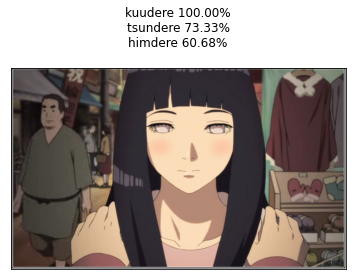

In [83]:
#@title Test on waifu images from internet
'''
Steps:
  1. Resize to 256x256
  2. Convert it to Tensor
  3. Normalize pixel values
  4. Pass the Tensor to the model
  5. Find the position of max value returned from the NN
  6. Check the class of the input
  7. Print the Prediction
'''
from torchvision import transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import requests, torch, warnings
warnings.filterwarnings("ignore")
from PIL import Image

class_list = [
    'dandere',
    'deredere',
    'himdere',
    'kuudere',
    'tsundere',
    'yandere',
    'yangire'
]

resnet = resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features,7)
resnet.load_state_dict(torch.load("/content/drive/MyDrive/waifus/Workspace/Models/RESNET1864bat20epochLR015.pth"))
transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img_url = "https://honeysanime.com/wp-content/uploads/2016/06/Hinata-naruto-Capture.jpg" #@param {type:"string"}
# img_obj = urllib.urlopen(img_url)
img = Image.open(requests.get(img_url, stream=True).raw)
img_processed = transform(img)
preds = resnet(img_processed.unsqueeze(0))
preds = preds.cpu().data.numpy()
f = plt.imshow(img)
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
pred = ''
idx = np.argsort(preds[0])
idx = idx.tolist()

if type(preds) != list:
  preds = preds.tolist()
for i in idx[::-1][:3]:
  pred+= f"{class_list[i]} {(preds[0][i]/preds[0][idx[-1]])*100:.2f}%\n"
plt.title(
    pred,
    loc='center'
);
